# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model to data from [two deep mutational scanning experiments](https://github.com/dms-vep) across Delta and Omicron BA.2 Spike protein.

In [1]:
import os
import sys
from collections import defaultdict
import time
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%matplotlib inline

## Inputs


You can initialize a `MultiDmsData` object with a ``pd.DataFrame``
with a row for each variant sampled and annotations
provided in the required columns:

1. **condition** - Experimental condition from
    which a sample measurement was obtained.
2. **aa_substitutions** - Defines each variant $v$ as a string of substitutions (e.g., 'M3A K5G').
    Note that while conditions may have differing wild types
    at a given site, the sites between conditions should reference
    the same site when alignment is performed between
    condition wild types. Finally, be sure wildtype variants have an empty string in this column
3. **func_score** - The functional score computed from experimental
    measurements.


In [2]:
func_score_df = pd.read_csv("func_score_df_example.csv").fillna("")
func_score_df

,func_score,aa_substitutions,condition
0,-2.7109,L5P D142A G181R T1027V,Delta-3
1,0.4763,R357G T604I,Delta-3
2,-3.5000,C671Y G1167S,Delta-3
3,-0.8302,E619D I997V,Delta-3
4,-2.0923,M902I G1246C,Delta-3
...,...,...,...
132188,0.8244,P521S T523A V785L S1249F,Omicron_BA.2-1
132189,-0.3023,K206N G213M Y1215H,Omicron_BA.2-1
132190,-2.8711,F133Y S1030C,Omicron_BA.2-1
132191,-0.2702,L18T G75P,Omicron_BA.2-1


## Instantiate a `MultiDmsData` object

After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will; (1) infer the wildtype site map for each of the conditions observed in te input data (2) convert substitution string to be with respect to a reference (if necessary) (3) set static attributes and (4) prep model training data as [binarymap objects](https://github.com/jbloomlab/binarymap).

**Note**: We infer the wildtype sequence site map from the data provided. In the case where conditions have differing wildtypes, we convert non-identical site mutations to be relative to the reference wildtype. See the biophysical additive latent phenotype section of the documentation for more on this.

**Note**: Once initialized the data object can be shared by multiple `multidms.MulitDmsModel` objects for independent fitting.

In [3]:
data = multidms.MultiDmsData(
    func_score_df,
    alphabet = multidms.AAS_WITHSTOP,
    condition_colors = sns.color_palette("Paired"),
    reference = "Delta-3",
    verbose = True
)

inferring site map for Delta-3
inferring site map for Omicron_BA.2-1
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for Delta-3
is reference, skipping
Converting mutations for Omicron_BA.2-1


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


The resulting object includes a few useful attributes which we describe below. 

**MultiDmsData.site_map** gives us the wildtype aa's inferred for each experimental wildtype in the form of a `pd.DataFrame`. 

In [4]:
data.site_map.head()

,Delta-3,Omicron_BA.2-1
1,M,M
2,F,F
3,V,V
4,F,F
5,L,L


In [5]:
data.mutations[:5]

('M1F', 'M1I', 'M1K', 'M1L', 'M1N')

In [6]:
data.mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta-3,times_seen_Omicron_BA.2-1
0,M1F,M,1,F,5.0,0.0
1,M1I,M,1,I,6.0,6.0
2,M1K,M,1,K,3.0,0.0
3,M1L,M,1,L,3.0,0.0
4,M1N,M,1,N,4.0,0.0


In [7]:
data.conditions

('Delta-3', 'Omicron_BA.2-1')

In [8]:
data.reference

'Delta-3'

In [9]:
data.binarymaps

{'Delta-3': <binarymap.binarymap.BinaryMap at 0x7fb967a4f550>,
 'Omicron_BA.2-1': <binarymap.binarymap.BinaryMap at 0x7fb967896a50>}

In [10]:
data.non_identical_sites

frozendict.frozendict({'Delta-3': [], 'Omicron_BA.2-1':     Delta-3 Omicron_BA.2-1
19        R              I
27        A              S
156       G              E
213       V              G
339       G              D
371       S              F
373       S              P
375       S              F
376       T              A
405       D              N
408       R              S
417       K              N
440       N              K
452       R              L
477       S              N
484       E              A
493       Q              R
498       Q              R
501       N              Y
505       Y              H
655       H              Y
679       N              K
681       R              H
764       N              K
796       D              Y
950       N              D
954       Q              H
969       N              K})

In [11]:
data.non_identical_mutations

frozendict.frozendict({'Delta-3': '', 'Omicron_BA.2-1': 'R19I A27S G156E V213G G339D S371F S373P S375F T376A D405N R408S K417N N440K R452L S477N E484A Q493R Q498R N501Y Y505H H655Y N679K R681H N764K D796Y N950D Q954H N969K'})

## `MultiDmsModel`

Next, we create a model object which initializes and stores the model parameters. These parameters are determined primarily by the substitutions observed in the data, and the (post-latent) epistatic and output activation functions you choose. These model functions are defined in the `multidms.biophysical` module. By default, the model will use identity functions for both of these model components - boiling things down to a linear model.

Here we define a model with a `multidms.model.sigmoidal_global_epistasis` epistasis function, and fit the model. Note, running the fit on CPU's can be quite slow with large amounts of data. Below, we run 500 iterations on the sample dataset (loaded at the top of this notebook). On CPU this reportedly takes ~ 6 minutes. However running on GPU's reduces fitting time by 1-2 orders of magnitude. 

In [12]:
model = multidms.MultiDmsModel(
        data,
        epistatic_model=multidms.biophysical.sigmoidal_global_epistasis,
)

start = time.time()
model.fit(lasso_shift=1e-5, maxiter=500, tol=1e-6)
end = time.time()
print(f"done. fitting time = {round(end - start, 2)} seconds")

done. fitting time = 422.25 seconds


The Model object shares many similar properties from the data object, like mutations and variants dataframes, but the getters give you useful model-specific features like parameters and predictions.

In [13]:
model.mutations_df

,mutation,wts,sites,muts,times_seen_Delta-3,times_seen_Omicron_BA.2-1,β,S_Omicron_BA.2-1
0,M1F,M,1,F,5.0,0.0,-1.210919,0.000000
1,M1I,M,1,I,6.0,6.0,-0.486049,-0.060109
2,M1K,M,1,K,3.0,0.0,-0.885140,0.000000
3,M1L,M,1,L,3.0,0.0,-1.622761,0.000000
4,M1N,M,1,N,4.0,0.0,0.650301,0.000000
...,...,...,...,...,...,...,...,...
9600,S1252T,S,1252,T,27.0,82.0,0.031921,-0.118226
9601,S1252V,S,1252,V,14.0,61.0,0.274565,0.164877
9602,S1252W,S,1252,W,4.0,22.0,-0.789650,0.442587
9603,S1252Y,S,1252,Y,21.0,108.0,0.743249,0.139617


In [14]:
model.variants_df

,condition,aa_substitutions,weight,func_score,var_wrt_ref,predicted_latent,predicted_func_score,corrected_func_score
0,Delta-3,,2566,-0.193454,,2.486076,-0.793624,-0.193454
1,Delta-3,A1015D,1,-3.500000,A1015D,2.143910,-0.871995,-3.500000
2,Delta-3,A1015T G1204D K1245Y,2,-0.710050,A1015T G1204D K1245Y,4.281080,-0.617114,-0.710050
3,Delta-3,A1016D,1,-0.417800,A1016D,3.163691,-0.692286,-0.417800
4,Delta-3,A1016D V1176R,1,-2.225200,A1016D V1176R,0.610813,-1.561746,-2.225200
...,...,...,...,...,...,...,...,...
71854,Omicron_BA.2-1,Y91H N710T A1070G V1129L,2,-2.737200,R19I A27S G156E V213G G339D S371F S373P S375F ...,-2.844277,-3.215982,-2.830378
71855,Omicron_BA.2-1,Y91H T108L D287G A701T S939H,1,-3.500000,R19I A27S G156E V213G G339D S371F S373P S375F ...,-4.316606,-3.327777,-3.593178
71856,Omicron_BA.2-1,Y91N D138N Q474E,2,-2.874750,R19I A27S G156E V213G G339D S371F S373P S375F ...,1.379855,-1.140472,-2.967928
71857,Omicron_BA.2-1,Y91N N603I S1252Y,1,-0.887400,R19I A27S G156E V213G G339D S371F S373P S375F ...,1.641208,-1.032301,-0.980578


The the raw jax arrays of model parameters are always accessible via

In [15]:
model.params

{'C_Delta-3': Array([0.], dtype=float64),
 'C_Omicron_BA.2-1': Array([0.], dtype=float64),
 'C_ref': Array([2.48607639], dtype=float64),
 'S_Delta-3': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'S_Omicron_BA.2-1': Array([ 0.        , -0.06010947,  0.        , ...,  0.44258737,
         0.13961744, -0.10067284], dtype=float64),
 'α': {'ge_bias': Array([-3.37185356], dtype=float64),
  'ge_scale': Array([2.79283101], dtype=float64)},
 'β': Array([-1.21091915, -0.48604867, -0.88513987, ..., -0.78964969,
         0.74324948,  1.28377337], dtype=float64),
 'γ_Delta-3': Array([0.], dtype=float64),
 'γ_Omicron_BA.2-1': Array([-0.09317808], dtype=float64)}

### Visualization

There exists a few useful plotting methods for the `MultiDmsModel` object.

<function matplotlib.pyplot.show(close=None, block=None)>

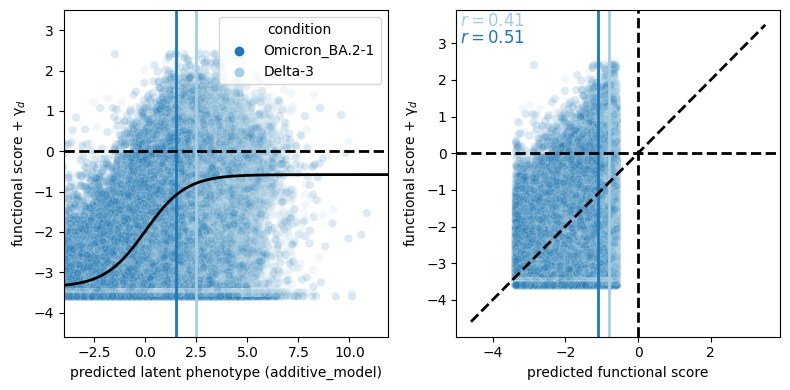

In [16]:
fig, ax = plt.subplots(1, 2, figsize=[8,4])
model.plot_epistasis(ax=ax[0], alpha=0.15, show=False)
model.plot_pred_accuracy(ax=ax[1], alpha=0.15, show=False, legend=False)
plt.show

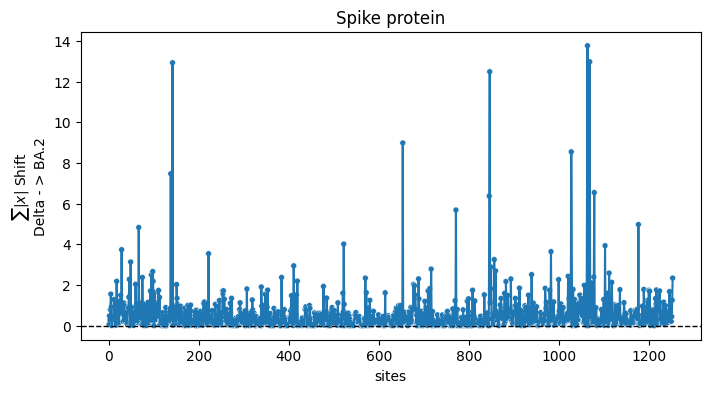

In [22]:
fig, ax = plt.subplots(figsize=[8,4])
agg_func = lambda x: onp.abs(onp.mean(onp.sum(x)))
model.plot_shifts_by_site(ax=ax, condition="Omicron_BA.2-1", agg_func=agg_func, show=False)
ax.set_ylabel("$\sum |x|$ Shift\nDelta - > BA.2")
ax.set_title("Spike protein")
plt.show()

We offer the ability to interactively visualize a model's shift parameters using the `MultiDmsModel.mut_shift_plot()` method which calls to a modified function from the original `polyclonal.plot.lineplot_and_heatmap()` as seen [here](https://github.com/jbloomlab/polyclonal/blob/92fee4badb14e1db719074f202b4fab374dd0613/polyclonal/plot.py#L263) 

**NOTE:** Currently, the heatmaps place an "X" at the wildtype for the reference sequence _only_. All non-identical wildtypes are marked with dot, on the respective shifts parameter heatmap, in the respective condition color at the correct wildtype position.

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
import multidms.plot

In [31]:
multidms.plot.mut_shift_plot(model, include_beta=False)

alt.VConcatChart(...)

Finally, we can save the tuned model via `pickle`

In [ ]:
import pickle
pickle.dump(model, open("test_dump.pkl","wb"))